<a href="https://colab.research.google.com/github/natnj/NJ-projects-pub/blob/main/MLCB_Homework_4_NJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLCB Homework 4

**Due: Monday Nov 13th at 11:59 PM EDT**

If you have any questions, please ask on piazza or at office hours!

Copy this notebook, and answer all questions directly in this notebook and complete the missing code where marked with **COMPLETE HERE**.

When you are done, submit the .ipynb file as well as PDF to Canvas.

## 0. Setup (run this)

In [1]:
!pip install scikit-learn
!pip install scipy
!pip install numpy
!pip install scanpy
!pip install anndata
!pip install leidenalg
!pip install rdkit

import scanpy as sc
import anndata
import os
import pandas as pd
import scipy.io as io
import numpy as np
from google.colab import files
from scipy.spatial.transform import Rotation
from rdkit import Chem
from rdkit.Chem import AllChem

## Download the data
!wget -c -O data.zip https://www.dropbox.com/sh/4f9fmenyvmrffj2/AAAmNwJtO8ZKTaRkZoltTCHsa?dl=0
!unzip -o data.zip -d data

!wget -c -O diffdock.zip https://www.dropbox.com/scl/fi/e23wyl4bfolckjaaablhc/diffdock.zip?rlkey=80p9a46yivyc3jdi7jnq7bnx9&dl=0
!unzip -o diffdock.zip -d diffdock


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.8 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.4-py3-none-any.whl size=86770 sha256=9d8156c272f5434fcb5526128e708761e043af93c78c5a6ca22d11c78cdc16ff
  Stored in directory: /root/.cache/pip/wheels/fb/66/29/199acf5784d0f7b8add6d466175ab45506c96e386ed5dd0633
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=dc75b5529266b607cf31faa66593d792af9a4eb8f327e72c41c69586d38135bd
  Stored in directory: /root/.cache/pip/wheels/6a

## 1. Single-cell RNA-seq Data Analysis

In this problem, we will analyse single cell RNA-seq data, including clustering, identifying marker genes per cell type and look at differential expression under varied conditions.

First run the extra setup below:

In [15]:
## Read data and create anndata object
# load sparse matrix :
X = io.mmread("data/counts.mtx")
# create anndata object
adata = anndata.AnnData(X=X.transpose().tocsr() )
# load cell metadata:
cell_meta = pd.read_csv("data/meta.csv")
# load gene names:
with open("data/gene_names.csv", 'r') as f:
    gene_names = f.read().splitlines()
# set anndata observations and index obs by barcodes, var by gene names
adata.obs = cell_meta
adata.obs.index = adata.obs['barcode']
adata.var.index = gene_names
print(adata)

AnnData object with n_obs × n_vars = 5820 × 16409
    obs: 'n_counts', 'pct_ribo', 'pct_mito', 'n_genes', 'major.celltype', 'cell_type_high_resolution', 'condition', 'age', 'sex', 'patientID', 'barcode'


In [16]:
## Since the provided data was pre-processed, we will skip the data fitering steps.
## Perform log-transformation, scale data, and identify highly variable genes
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

### 1.A Visualization and Clustering

In this part, you will perform dimensionality reduction (PCA) technique to emphasize the main axes of variation in the data, compuate neighborhood graph to identify clusters of cells that have similar expression patterns, run tSNE and UMAP for further dimensionality reduction to visualize clusters in 2D, and find clusters using Leiden graph-clustering method based on the neighborhood graph of cells, which you already computed in the previous section. Please use the scanpy build-in functions for this question.

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


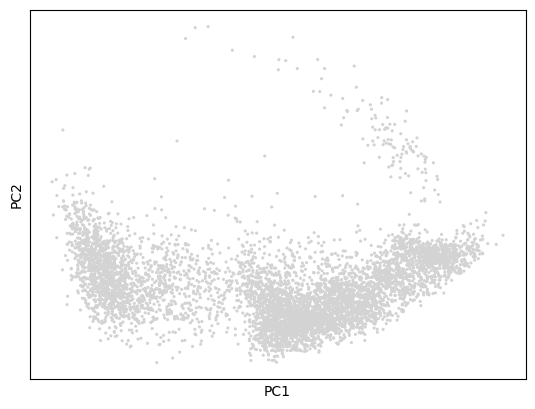

In [17]:
import matplotlib.pyplot as plt
## Run PCA and plot
sc.tl.pca(adata)
sc.pl.pca(adata)


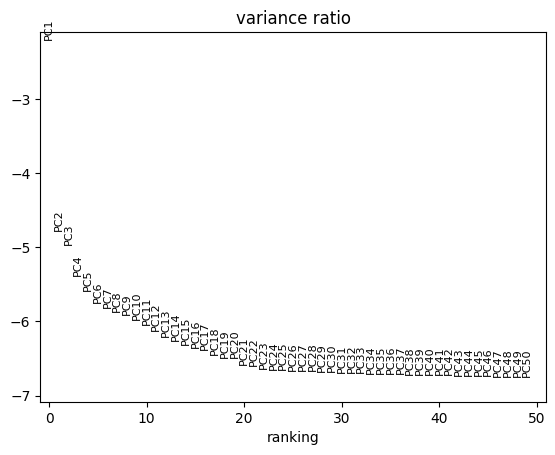

In [18]:
## Number of PCs selection
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)


In [19]:
## Compute neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, method='umap', metric='cosine', knn=True)

# Optionally, you can compute a force-directed layout for visualization

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


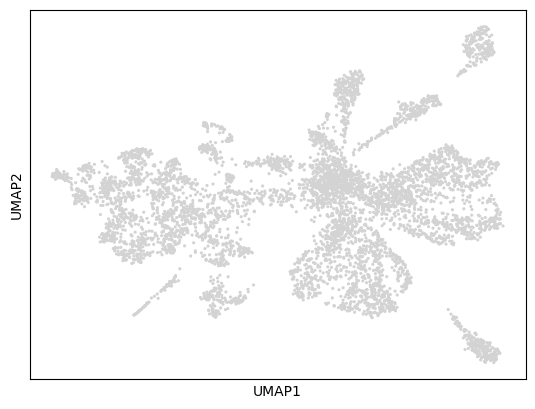

In [24]:
## Run clustering and plot
sc.tl.umap(adata)
sc.pl.umap(adata)
plt.show()

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


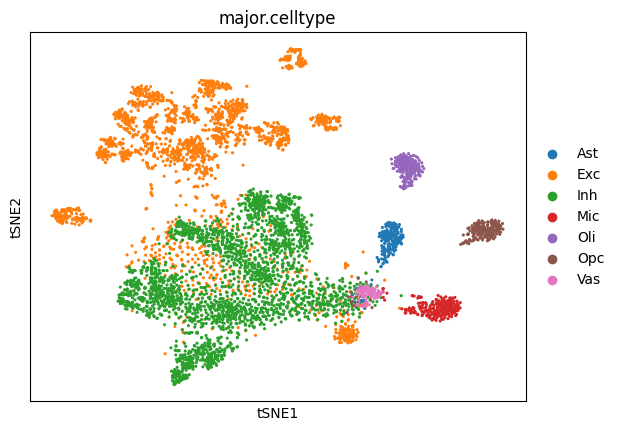

In [22]:
## Run tSNE and plot, colored by cluster id which you get in the clustering step, colored by "major.celltype" in the metadata
sc.tl.tsne(adata)
sc.pl.tsne(adata, color='major.celltype')
plt.show()

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


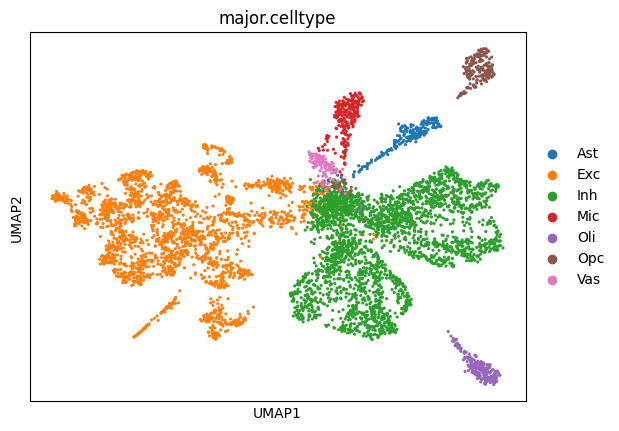

In [23]:
## Run UMAP and plot, colored by cluster id which you get in the clustering step, colored by "major.celltype" in the metadata
sc.tl.umap(adata)
sc.pl.umap(adata, color='major.celltype')
plt.show()

Compare the plots of tSNE and UMAP. Please also discuss the differences between these two methods in general.

**ANSWER:**

### 1.B Find marker genes per cluster and annotate cell type

In this part, you will identify marker genes for each cluster and use the reference marker panel to annotate the cell type for each cluster.
Reference marker genes for the brain cell types:

Markers | Cell Type
---|---
SYT1,SNAP25,GRIN1 | Neurons
NRGN, SLC17A7,CAMK2A | Excitatory neurons
GAD1,GAD2 |	Inhibitory neurons
AQP4,GFAP |	Astrocytes
MBP, MOBP,PLP1 | 	Oligodendrocytes
CSF1R, CD74,C3 |	Microglia
VCAN, PDGFRA,CSPG4 |	Oligodendrocyte progenitor cells (Opc)
FLT1,CLDN5,AMBP |	Vascular cells

In [44]:
# Find marker genes
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test', reference='rest')
marker_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
reference_markers=["SYT1","SNAP25","GRIN1","NRGN", "SLC17A7","CAMK2A",
"GAD1","GAD2","AQP4","GFAP","MBP", "MOBP","PLP1",
"CSF1R", "CD74","C3","VCAN", "PDGFRA","CSPG4","FLT1","CLDN5","AMBP"]
cellType=["Neurons", "Excitatory neurons",	"Inhibitory neurons", "Astrocytes", "Oligodendrocytes", "Microglia",
          "Oligodendrocyte progenitor cells (Opc)",	"Vascular cells"]
# Annotate cell types using the reference marker panel

cell_type_annotations = pd.DataFrame(index=adata.obs.index)


for cell_type in reference_markers:
    reference_genes = reference_markers.index[reference_markers[cell_type] == 1].tolist()

    # Check which reference genes are also marker genes in the clusters
    overlapping_genes = marker_genes[marker_genes.isin(reference_genes).any(axis=1)].stack().unique()

    # Assign cell type annotation to cells with overlapping marker genes
    cell_type_annotations[cell_type] = adata_markers.obs_names.isin(overlapping_genes)

# Sum the annotations across cell types to get the most likely cell type for each cell
most_likely_cell_type = cell_type_annotations.idxmax(axis=1)

# Add the cell type annotations to the AnnData object
adata.obs['cell_type'] = most_likely_cell_type

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: 

TypeError: ignored

In [49]:
# Load the reference marker genes
reference_markers = ["SYT1","SNAP25","GRIN1","NRGN", "SLC17A7","CAMK2A",
                     "GAD1","GAD2","AQP4","GFAP","MBP", "MOBP","PLP1",
                     "CSF1R", "CD74","C3","VCAN", "PDGFRA","CSPG4","FLT1","CLDN5","AMBP"]
cell_types = ["Neurons", "Excitatory neurons", "Inhibitory neurons", "Astrocytes",
              "Oligodendrocytes", "Microglia", "Oligodendrocyte progenitor cells (Opc)", "Vascular cells"]

# Find marker genes
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test', reference='rest')
result = adata.uns['rank_genes_groups']

# Extract marker genes and scores
groups = result['names'].dtype.names
marker_genes = pd.DataFrame({group: result['names'][group] for group in groups})
marker_scores = pd.DataFrame({group: result['scores'][group] for group in groups})

# Create a dictionary to map marker genes to cell types
marker_to_cell_type = {}
for cell_type, genes in zip(cell_types, reference_markers):
    marker_to_cell_type.update({gene: cell_type for gene in genes})
# Annotate cell types based on marker genes
cell_type_annotations = pd.DataFrame(index=adata.obs_names)
for cell_type, genes in zip(cell_types, reference_markers):
    overlapping_genes = marker_genes[cell_types.index(cell_type)].loc[marker_genes[cell_types.index(cell_type)].isin(genes)]
    cell_type_annotations[cell_type] = adata.obs_names.isin(overlapping_genes)

# Sum the annotations across cell types to get the most likely cell type for each cell
most_likely_cell_type = cell_type_annotations.idxmax(axis=1)

# Add the cell type annotations to the AnnData object
adata.obs['cell_type'] = most_likely_cell_type


/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: 

KeyError: ignored

In [42]:
# plot UMAP colored with your cell type annotation and compare it with the "major.celltype" in the metadata
print(cell_type_annotations)
#most_likely_cell_type = cell_type_annotations.idxmax(axis=1)
#print(most_likely_cell_type)
#sc.tl.umap(adata)

#sc.pl.umap(adata)

Empty DataFrame
Columns: []
Index: [SM_IXFTR_CTCGAGGGTCAAACGG-2, SM_IXFTR_CGGAGAAGTGTTCATG-2, SM_IXFTR_TTTATGCCAGAGGAAA-2, SM_IXFTR_TTACAGGCAAAGGATT-2, SM_IXFTR_CTACGGGGTAAGGAGA-2, SM_IXFTR_TTCATTGAGTAAAGCT-2, SM_IXFTR_CCCTCAAGTCGTTATG-2, SM_IXFTR_GCGGAAATCTGTTCAT-2, SM_IXFTR_CATCCCATCACTCGAA-2, SM_IXFTR_TATTGCTGTCCTGGGT-2, SM_IXFTR_GAAATGATCCGTGACG-2, SM_IXFTR_GTGCTGGAGATGGCAC-2, SM_IXFTR_GGGTAGATCTATCGCC-2, SM_IXFTR_CTGCGAGCATAAGATG-2, SM_IXFTR_ATCCCTGAGGCGCTCT-2, SM_IXFTR_AAAGGTACAGTCTCTC-2, SM_IXFTR_GGGATGATCAAGAGTA-2, SM_IXFTR_AACCTGAGTCCAGGTC-2, SM_IXFTR_ATCGGATAGCCTAGGA-2, SM_IXFTR_TCAGCCTGTTTAGTCG-2, SM_IXFTR_ACGTAACCAGCTATAC-2, SM_IXFTR_CAATGACAGTGGAAAG-2, SM_IXFTR_TCATGCCCATGCTGCG-2, SM_IXFTR_TTGATGGCACAGAGAC-2, SM_IXFTR_TGTCCACTCGGAAACG-2, SM_IXFTR_GTCTTTATCGGACTTA-2, SM_IXFTR_TGTGTGACAAGTCGTT-2, SM_IXFTR_TACATTCCAAGGGCAT-2, SM_IXFTR_CACGGGTTCACCTTAT-2, SM_IXFTR_ACGTACAAGTTCGCAT-2, SM_IXFTR_TGGATGTTCATGGCCG-2, SM_IXFTR_CAGCAATGTCGAATGG-2, SM_IXFTR_CGATGCGAGAATCTAG-2, SM_IXFT

Please describe your observation of the comparison between your annotation and "major.celltype".

**ANSWER:**

### 1.C Differential Gene Expression Analysis between Conditions

In this part, we will identify differentially expressed genes (DEGs) between conditions (AD vs. nonAD) per cell type. You may find the "condition" in the metadata. Please call DEGs using two methods: wilcoxon and t-test, visulize the top 10 DEGs per group, and compare your results between two methods and visulize the comparison using venn diagram. For each cell type, you will generate two comparions (up-regulated in AD; up-regulated in nonAD).

In [ ]:
# Your code and plot

**ANSWER:** explain your findings here

## 2. Molecular Docking








In lecture we studied the task of molecular docking: given a protein target's structure in 3D, we wish to find the 3D coordinates of a known ligand binder. In particular we showed some deep learning approaches to the problem.

In this problem, we first review the question of symmetry preserving models, which is particuarly important to 3D tasks such as molecular docking. Then, we will run a few docking predictions using DiffDock (https://arxiv.org/abs/2210.01776) and analyze them.

### 2.A Invariance & Equivariance

Because the docking task is inherently a 3D task (i.e we are predicting coordinates), it's important to think about the geometrical symmetries that we wish our model to handle gracefully. We call this family of models "invariant" or "equivariant" to a group transformation. This is particularly neat property that significantly reduces the space of functions that the model considers, helping optimization and generalization.

#### 2.A.1 Question

What does it mean for a model to be invariant to translations and rotations of the input? How about equivariant? Give a simple mathematical definition using `f` as the model function, `x` as the input, `R` as a rotation matrix, and `t` as a translation vector.

**ANSWER**:

#### 2.A.2 Question

There are many ways to achieve invariance / equivariance, and it is currently a very active area of research. Here, we will study the the Equivariant Graph Neural Network (EGNN)  model by Satoras et. al: (https://arxiv.org/pdf/2102.09844.pdf).

Recall the GNN layer we implemented in Homework 2, with node features `h` and edge features `e`. We compute messages for each edge, aggregate the messages and used the result to update the features:

$$ \begin{align} m_{ij} &= MLP(h_i, h_j, e_{ij}) \\
 m_i &= \frac{1}{N} \sum_j m_{ij} \\
 \tilde{h_i} &= MLP(h_i, m_i) \end{align}$$


An EGNN layer is very similar, defined by the following set of equations, given a set of input features `h` and coordinates `x`:

$$ \begin{align} m_{ij} &= MLP(h_i, h_j, e_{ij}, ||x_i - x_j||^2) \\
 m_i &= \frac{1}{N} \sum_j m_{ij} \\
h_{new} &= MLP(h_i, m_i) \\
x_{new} &= x_i + \frac{1}{N} \sum_j MLP(m_{ij}) \cdot (\vec{x_i}- \vec{x_j}) \end{align}$$


The only changes are the use of pairwise distances in the first equation and the coordinate update in the last equation.

Prove that EGNN is indeed equivariant to translation and rotation by showing that applying a rotation `R` and translation `t` to the input `x_i` and `x_j` is equivalent to applying it to the output `x_new`.


**ANSWER**:

#### 2.A.3 Question

We will now implement the EGNN and verify its equivariance. Fill out the code below.



In [ ]:
# HELPERS
class MLP(object):
  """A random two layer neural network."""

  def __init__(self, in_dim, out_dim):
    self.w1 = np.random.randn(in_dim, out_dim)
    self.b1 = np.random.randn(out_dim)
    self.w2 = np.random.randn(out_dim, out_dim)
    self.b2 = np.random.randn(out_dim)

  def forward(self, h):
    h_new = np.dot(h, self.w1) + self.b1
    h_new = h_new * (h_new > 0)
    h_new = np.dot(h_new, self.w2) + self.b2
    return h_new

  def __call__(self, h):
    return self.forward(h)


def apply_transform(R, t, x):
  """Apply a rotation and translation to a set of points."""
  return np.dot(x, R.T) + t


# COMPLETE BELOW
class EGNN(object):

  def __init__(self, dim):
    """Random weight initialization."""
    self.message_mlp = MLP(dim * 3 + 1, dim)
    self.feature_mlp = MLP(dim * 2, dim)
    self.coords_mlp = MLP(dim, 1)

  def forward(self, h, e, x):
    """Apply an EGNN layer.

    Parameters
    ----------
    h:
      node features as a numpy array of shape (N, D)
    e:
      edge features as a numpy array of shape (N, N, D)
    x:
      set of points in 3D as a numpy array of shape (N, 3)

    Returns
    -------
    h_new:
      new node features as a numpy array of shape (N, D)
    x_new:
      new set of points in 3D as a numpy array of shape (N, 3)

    """
    # COMPLETE HERE

    # Expand h to get all pairs of h's, your final dimension should be (N, N, 2 * D)
    # You can expand with dummy dimensions and then use np.repeat

    # Get all x_i - x_j vectors (you can just broadcast, without repeat)

    # Compute the squared norm of the x_ij vectors

    # Concatenate h pairs, distances, and edge features

    # Compute messages for all i, j pairs

    # Aggregate messages per node (sum across j)

    # Update features

    # Update coordinates
    pass


# DO NOT MODIFY BELOW
def test_equivariance():
  # Set parameters
  N = 64
  D = 32
  h = np.random.randn(N, D)
  e = np.random.randn(N, N, D)
  x = np.random.randn(N, 3)
  egnn = EGNN(D)

  # Sample a random roto-translation
  R = Rotation.random().as_matrix()
  t = np.random.randn(3)
  x_rot = apply_transform(R, t, x)

  # Run model on x
  _, x_new = egnn.forward(h, e, x)
  x_new_rot = apply_transform(R, t, x_new)

  # Run the model on x_rot
  _, x_rot_new = egnn.forward(h, e, x_rot)

  # Compare the outputs
  if np.linalg.norm(x_new_rot - x_rot_new, axis=-1).max() < 1e-4:
    print("Equivariance test passed!")
  else:
    print("Equivariance test failed!")


test_equivariance()

### 2.B DiffDock

In this second part, we will use a state of the art deep learning tool, DiffDock, to produce candidate docking structures. We will analyze the results to get some insight into the inner workings of the model.

DiffDock also uses a 3D equivariant model, though it is not the EGNN introduced above but a tensor field network. These are more complex, and we will not study them in this course. If you are interested, you may read more about them here:
https://arxiv.org/abs/1802.08219. For this problem, we will instead focus on a different charachteristic of DiffDock: the "diffusion" process.

#### 2.B.1 Question

DiffDock is a generative model. Explain the difference between a generative and a discriminative model.

**ANSWER**:

#### 2.B.2 Question

DiffDock is a specific type of generative model, namely a diffusion-based model. These models are trained to iteratively reverse a noise distribution (ex: gaussian) to the data distribution. Due to their generative nature, they can be sampled from, and every sample requires a certain number of denoising steps. For more info, see this very good blog post:

https://lilianweng.github.io/posts/2021-07-11-diffusion-models/

You are provided with pre-computed structures from DiffDock for this problem. If you are interested in making your own predictions you may use this colab notebook:

https://colab.research.google.com/github/hgbrian/biocolabs/blob/master/DiffDock.ipynb

We pre-computed docking results using the notebook above with different number of denoising steps (i.e inference steps): 5, 10, 20. For each setting we sampled 5 possible poses. First let's print the data we have.

In [ ]:
# RUN THIS
DIFFDOCK_DATA = "/content/diffdock/diffdock/"
GT_PATH = "6o5g_B_LMJ.sdf"

ground_truth = os.path.join(DIFFDOCK_DATA, GT_PATH)
predictions = []
for file_name in os.listdir(DIFFDOCK_DATA):
  if "rank" not in file_name:
    continue
  else:
    meta = file_name.split("_")
    group = meta[0]
    rank = int(meta[2][-1])
    confidence = float(meta[3].split("confidence")[1][:-4])
    predictions.append({
        "path": os.path.join(DIFFDOCK_DATA, file_name),
        "group": group,
        "rank": rank,
        "confidence": confidence
    })

print("Ground truth path:\n")
print(ground_truth)

print("\nPredictions:")
print(pd.DataFrame(predictions))

For each of the 3 groups (i.e 5, 10 and 20), report the best RMSD across the 5 samples. How did performance change as a function of the number of denoising steps?

In [ ]:
# HELPERS
def load_coordinates_sdf(path):
    """Load molecule from sdf."""
    suppl = Chem.SDMolSupplier(path)
    mol = next(suppl)
    return mol

def compute_rmsd(mol1, mol2):
    """Compute the RMSD between mol1 and mol2."""
    return Chem.rdMolAlign.CalcRMS(mol1, mol2)

# COMPLETE HERE

**ANSWER:**

#### 2.B.3 Question

Perform the same analysis, this time comparing strategies for measuring performance across the 5 samples:

- The mean RMSD (same as before)
- The best RMSD of the 5 samples
- The highest confidence ranked of the 5 samples

Comment on your observations.

In [ ]:
# COMPLETE HERE

**ANSWER:**

#### 2.B.4 Question

Visualize the worst and the best prediction (according to the RMSD) using the Molstar visualizer (https://molstar.org/viewer/).

You can just drag and drop the files directly on your browser, super easy. Make sure to visualize both the sdf file (molecule prediction) and the ground truth PDB (target protein + correct molecule pose). Take screenshots for tbe best and worst predictions and display them here.

In [ ]:
# Set the best file and download it by running this cell
# Do not include the /content/diffdock/diffdock prefix
best_prediction = ""
worst_prediction = ""

# Download
from google.colab import files

DIFFDOCK_DATA = "/content/diffdock/diffdock/"
files.download(os.path.join(DIFFDOCK_DATA, best_prediction))
files.download(os.path.join(DIFFDOCK_DATA, worst_prediction))
files.download(os.path.join(DIFFDOCK_DATA, "6O5G.pdb"))

Do you notice anything interesting about the "bad" prediction?

**ANSWER:**

#### 2.B.5 Question (Optional for all students)

Try your own! Find a known protein-drug interaction and attempt to dock the molecule. Here are the steps you can follow:

1. Find a known protein-drug interaction in the Drugbank: https://go.drugbank.com/
2. Get the PDB ID for the target protein (if there isn't one, look for a uniprot ID and find the predicted structure in the AlphaFold2 database: https://alphafold.ebi.ac.uk/)
3. Get the smiles string for the ligand
4. Dock using this notebook: https://colab.research.google.com/github/hgbrian/biocolabs/blob/master/DiffDock.ipynb
5. Display your prediction here, you can use https://molstar.org/viewer/